In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras import models, layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow.keras.backend as K
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import EfficientNetB3
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from functools import partial
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)
from tensorflow.keras.applications import DenseNet201, VGG19, Xception

Tensorflow version 2.4.0


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [4]:
from sklearn.utils import class_weight

y_train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
y_train = y_train.label.to_numpy()
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

weights = {i:class_weights[i] for i in range(5)}

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 3 1 ... 1 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 100

In [7]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


In [8]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [9]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset


In [11]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.35, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))



In [13]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [14]:
train_dataset_bf = load_dataset(TRAINING_FILENAMES)

def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


In [15]:
valid_dataset_bf = load_dataset(VALID_FILENAMES)

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [16]:
test_dataset_bf = load_dataset(TEST_FILENAMES)

def get_test_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


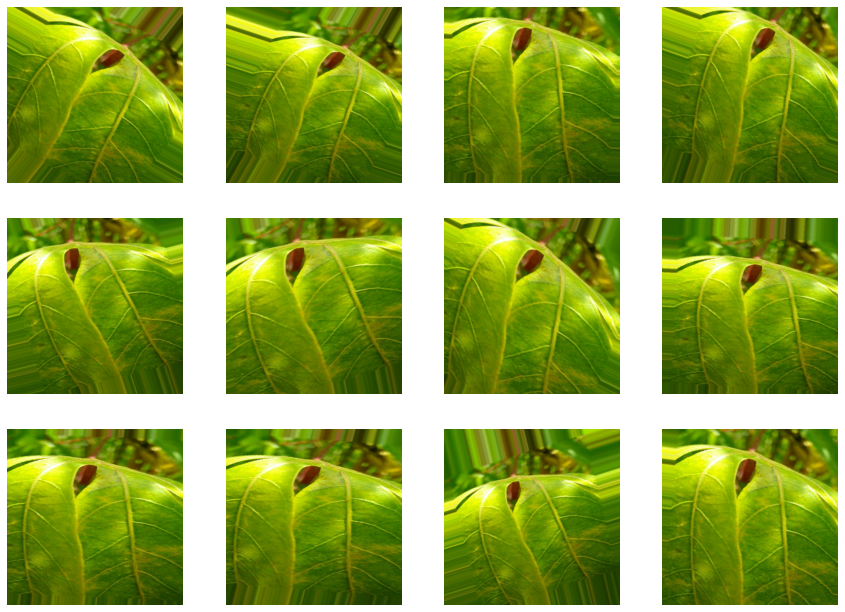

In [17]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [18]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [19]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 13380 training images, 8017 validation images, 1 (unlabeled) test images


In [20]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, 
    decay_steps=10000, 
    decay_rate=0.9)

In [21]:
model_check = ModelCheckpoint(
                            "./firstTry",
                            monitor = "val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode = "min")

In [22]:
# load data
train_dataset = get_training_dataset(train_dataset_bf)
valid_dataset = get_validation_dataset(valid_dataset_bf) 
test_dataset = get_test_dataset(test_dataset_bf)


In [23]:
with strategy.scope():       
    
    rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
    rnet.trainable = True
    
    vggnet = VGG19(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
    rnet.trainable = True
    
    xception = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    
)
    
#     model.add(layers.BatchNormalization(renorm=True))
#     model.add(EfficientNetB3(include_top = False, weights = "imagenet",
#                             input_shape=[*IMAGE_SIZE, 3]))
    
#     model.add(rnet)
    
    model = Sequential()

        
#     model.add(layers.BatchNormalization(renorm=True))
#     model.add(EfficientNetB3(include_top = False, weights = "imagenet",
#                             input_shape=[*IMAGE_SIZE, 3]))
    
#     model.add(rnet)

#     model.add(EfficientNetB3(include_top = False, weights = "imagenet",
#                             input_shape=[*IMAGE_SIZE, 3]))
#     model.add(rnet)
#     model.add(xception)
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2048, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, activation = "softmax"))
    

83689472/83683744 [==============================] - 1s 0us/step


In [24]:
save_path = './models/models.h5'
checkpoint = ModelCheckpoint(
        save_path, monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )

early_stop= EarlyStopping(monitor = "val_loss",
                          patience=40,
                        )

In [25]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-5), metrics=["accuracy"])

In [26]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks=[checkpoint, early_stop])#, class_weight=weights)

Epoch 1/100
104/104 [==============================] - 105s 540ms/step - loss: 2.0599 - accuracy: 0.2653 - val_loss: 1.2492 - val_accuracy: 0.6429
Epoch 2/100
104/104 [==============================] - 47s 452ms/step - loss: 1.5348 - accuracy: 0.4644 - val_loss: 1.0083 - val_accuracy: 0.6710
Epoch 3/100
104/104 [==============================] - 47s 450ms/step - loss: 1.3640 - accuracy: 0.5460 - val_loss: 0.8693 - val_accuracy: 0.7167
Epoch 4/100
104/104 [==============================] - 46s 446ms/step - loss: 1.2238 - accuracy: 0.5994 - val_loss: 0.7991 - val_accuracy: 0.7409
Epoch 5/100
104/104 [==============================] - 47s 448ms/step - loss: 1.1099 - accuracy: 0.6475 - val_loss: 0.7745 - val_accuracy: 0.7550
Epoch 6/100
104/104 [==============================] - 47s 447ms/step - loss: 1.0485 - accuracy: 0.6717 - val_loss: 0.7458 - val_accuracy: 0.7629
Epoch 7/100
104/104 [==============================] - 46s 447ms/step - loss: 1.0073 - accuracy: 0.6914 - val_loss: 0.7468 